<a href="https://colab.research.google.com/github/darchon30704/HAICON2021/blob/main/HAICon2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Dacon/HAICon2021'

In [ ]:
!pip3 install '/content/drive/MyDrive/Colab Notebooks/Dacon/HAICon2021/eTaPR-21.8.2-py3-none-any.whl'

Processing ./drive/MyDrive/Colab Notebooks/Dacon/HAICon2021/eTaPR-21.8.2-py3-none-any.whl


In [ ]:
from TaPR_pkg import etapr

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tqdm import tqdm
import sklearn.preprocessing as pp
import os
from datetime import timedelta
import dateutil

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange

from contextlib2 import redirect_stdout
import random

In [ ]:
train1 = pd.read_csv(PATH + '/train/train1.csv')



sample_submission = pd.read_csv(PATH + '/sample_submission.csv')

In [ ]:
# Feature Test 중 Seed 고정을 위해 사용하였음.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))


TRAIN_DATASET = sorted([x for x in Path(PATH+"/train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path(PATH+"/test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path(PATH+"/validation/").glob("*.csv")])

TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)
print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(1004402, 87)


,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,50,11704,17.61017,28.03686,27170,27.24188,25.42843,0,1,50,27.28778,31.02721,1,267.90363,467.27020,3865,50,14742,0.88504,1,54816,1009.15302,58.21227,5.5352,0,126.92957,2880,26.92264,0,0,...,48.64655,1,0,13752,41.81518,1,0.14465,0.46783,0,276.45758,476.76703,8.90254,49.26452,719.96625,1,923,0,0,16,0.08771,15.07713,9914,1,306.07104,28.20367,15.50464,251.23593,451.06253,26.13983,48.90190,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,50,11847,17.61780,28.03169,27171,27.24188,25.42656,0,1,50,27.28778,31.01196,1,268.95258,466.91238,3898,50,14781,0.88619,1,54816,1011.06647,57.44932,4.7507,0,126.92957,2880,26.92264,0,0,...,50.40893,1,0,13752,41.81518,1,0.14465,0.42892,0,278.91705,476.76703,8.90254,49.26452,720.10663,1,923,0,0,16,0.08771,14.97197,9914,1,303.09189,28.19449,16.20023,250.47298,404.38739,26.13983,48.94870,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,50,11953,17.61780,28.03504,27170,27.24188,25.41979,0,1,50,27.28778,31.01196,1,269.76636,466.91238,3892,50,14831,0.88836,1,54816,1009.79083,58.78445,5.5709,0,126.92957,2880,26.92264,0,0,...,50.60730,1,0,13760,41.81518,1,0.14465,0.42282,0,278.89899,476.76703,8.90254,49.26452,719.96625,1,923,0,0,16,0.08771,14.90129,9914,1,299.11945,28.18530,16.53352,249.90080,382.53925,26.14746,48.89090,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,50,12051,17.61780,28.03510,27171,27.24188,25.44255,0,1,50,27.28778,31.01196,1,271.64716,466.35010,3876,50,14917,0.89214,1,54816,1008.77380,59.16594,5.1828,0,126.92957,2880,26.92264,0,0,...,49.14246,1,0,13760,41.81518,1,0.14465,0.43121,0,280.49048,476.76703,8.90254,49.26452,720.00159,1,923,0,0,16,0.08771,14.82246,9914,1,306.07104,28.17612,16.30247,250.47298,396.44250,26.13983,48.95938,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,50,12180,17.61780,28.03510,27171,27.24188,25.44007,0,1,50,27.28778,31.02721,1,272.80457,466.60565,3871,50,14997,0.89191,1,54815,1009.79083,58.78445,5.1828,0,126.92957,2880,26.92264,0,0,...,47.18170,1,0,13760,41.81518,1,0.14465,0.45486,0,283.47437,476.76703,8.90254,49.26452,720.00159,1,923,0,0,16,0.08771,14.73087,9914,1,308.05728,28.16693,15.79237,250.28227,427.22849,26.13983,49.02211,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


In [ ]:
# Data Load & Merge
TRAIN_DATASET = sorted([x for x in Path(PATH + "/train/").glob("*.csv")]) # ------------------ Check 
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)

VALIDATION_DATASET = sorted([x for x in Path(PATH + "/validation/").glob("*.csv")])# ------------------ Check 
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)

TEST_DATASET = sorted([x for x in Path(PATH + "/test/").glob("*.csv")])# ------------------ Check 
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)

In [ ]:
DROP_FIELD = ["timestamp", 
              #"C02", "C03", "C14", "C18", "C19", "C21", "C22", "C25", "C33", "C34", "C35", "C37", "C40", "C43", "C51", "C52", "C59", "C61", "C63", "C64", "C65", "C67",
              #"C04", "C05", "C06", "C07", "C08", "C10", "C11", "C17", "C24", "C28", "C32", "C44", "C46", "C48", "C49", "C50", "C53", "C58", "C62", "C71", "C76", "C78", "C79"
              ]
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(DROP_FIELD) # DROP_FIELD를 통해 normalization에 사용하지 않을 변수를 제거함.
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [ ]:
# Min-Max Normalize
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

# Boundary Check
print(boundary_check(TRAIN_DF))
print(boundary_check(TEST_DF))

(False, False, False)
(True, True, False)


In [ ]:
class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False
    def __len__(self):
        return self.n_idxs
    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [ ]:
# Switch 파라미터를 통해서 검증그래프와 테스트그래프를 저장함
def check_graph(xs, att, piece=2, THRESHOLD=None, Switch=1):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        axs[i].set_ylim(0, 0.2)
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    if Switch == 1:
        plt.savefig(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS) + '_' + str(N_LAYERS) + '_' + str(BATCH_SIZE) + '_' + str(THRESHOLD) + '_' + 'evaluation.png')
    elif Switch == 2:
        plt.savefig(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS) + '_' + str(N_LAYERS) + '_' + str(BATCH_SIZE) + '_' + str(THRESHOLD) + '_' + 'baseline.png')


def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=8)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))

    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [ ]:
# 학습과정에서 Optimizer는 Baseline코드와 동일하며, L1Loss(MAE)로 변경하여 사용함
# 데이터 shuffle은 유지하였음
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    optimizer = torch.optim.AdamW(model.parameters())# ------------------- Check 
    loss_fn = torch.nn.L1Loss()# ------------------- Check 
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [ ]:
class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)
        self.relu = torch.nn.ReLU()# ------------------- Check 

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(self.relu(outs[-1]))# ------------------- Check 
        #out = self.fc(outs[-1])
        return x[0] + out

  0%|          | 0/1004315 [00:00<?, ?it/s]

# of valid windows: 1003880


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/86313 [00:00<?, ?it/s]

# of valid windows: 86313


  0%|          | 0/274713 [00:00<?, ?it/s]

# of valid windows: 274539


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/1004314 [00:00<?, ?it/s]

# of valid windows: 1003874


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/86312 [00:00<?, ?it/s]

# of valid windows: 86312


  0%|          | 0/274712 [00:00<?, ?it/s]

# of valid windows: 274536


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/1004313 [00:00<?, ?it/s]

# of valid windows: 1003868


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/86311 [00:00<?, ?it/s]

# of valid windows: 86311


  0%|          | 0/274711 [00:00<?, ?it/s]

# of valid windows: 274533


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


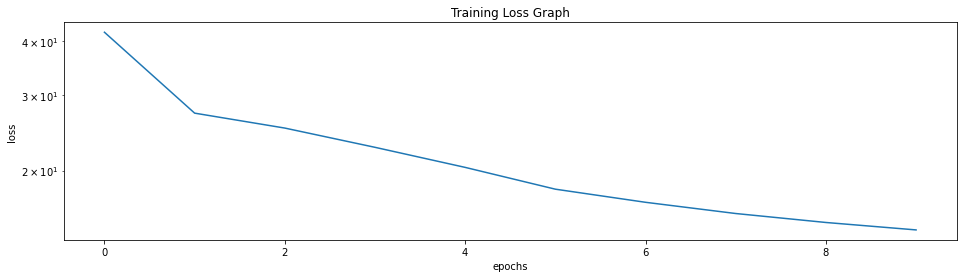

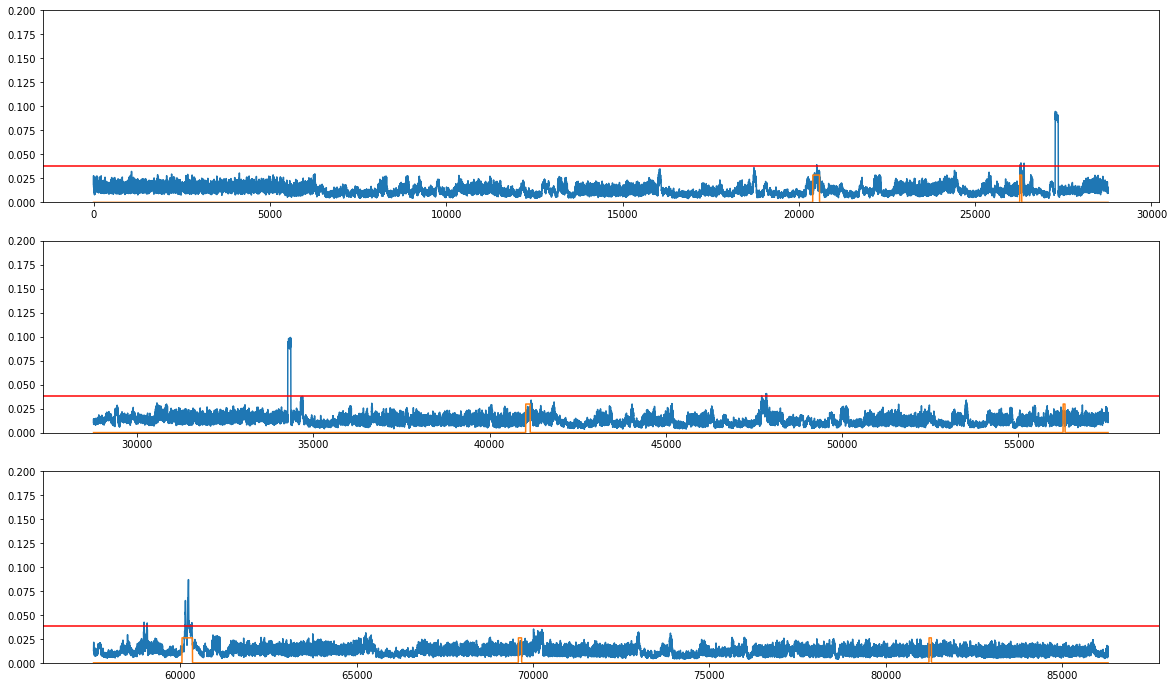

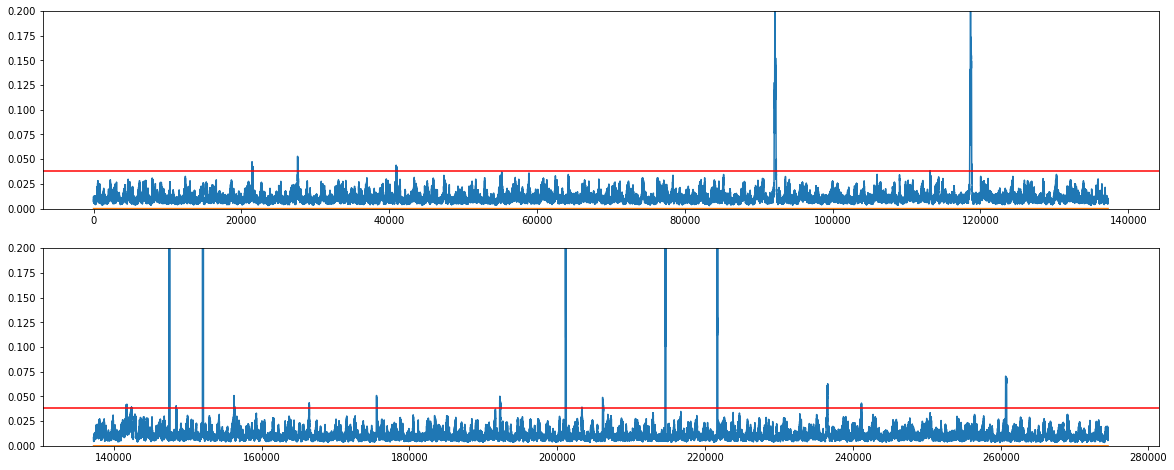

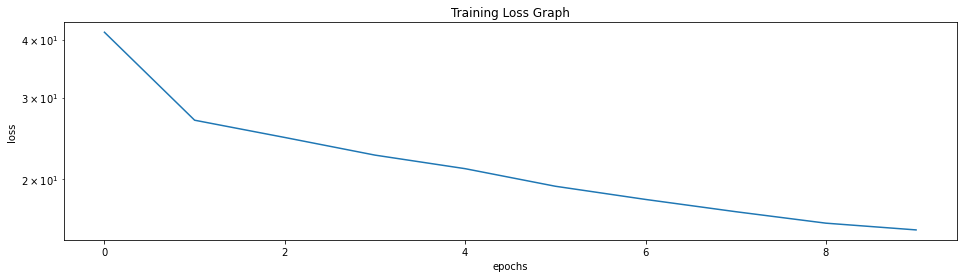

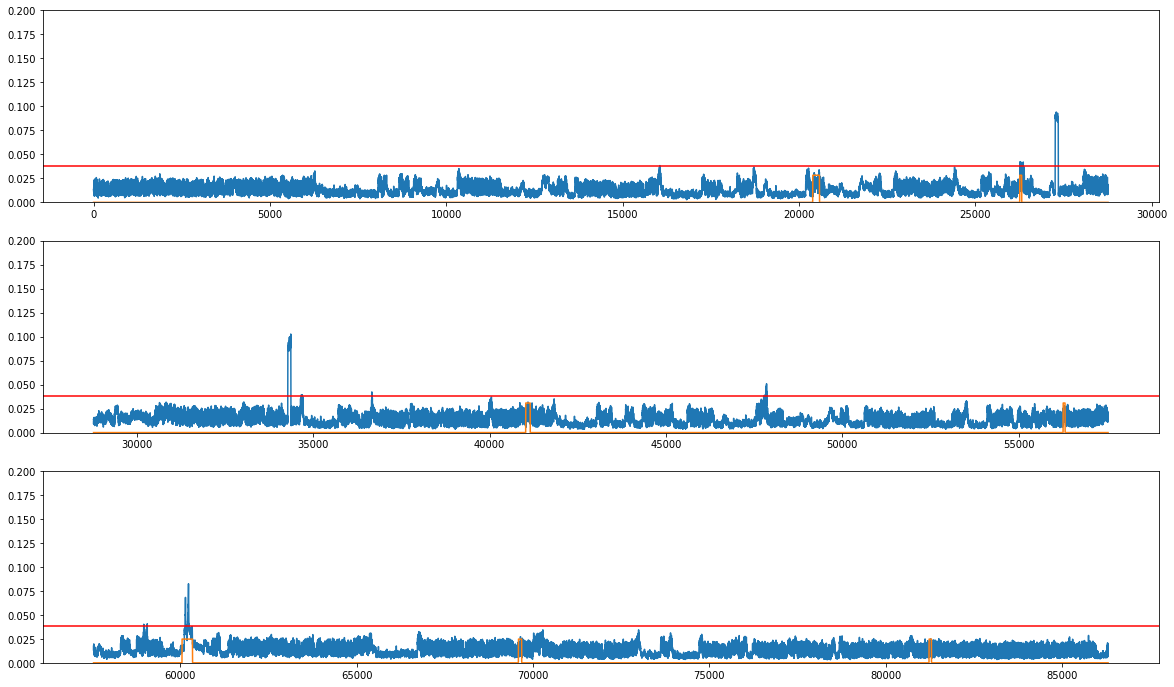

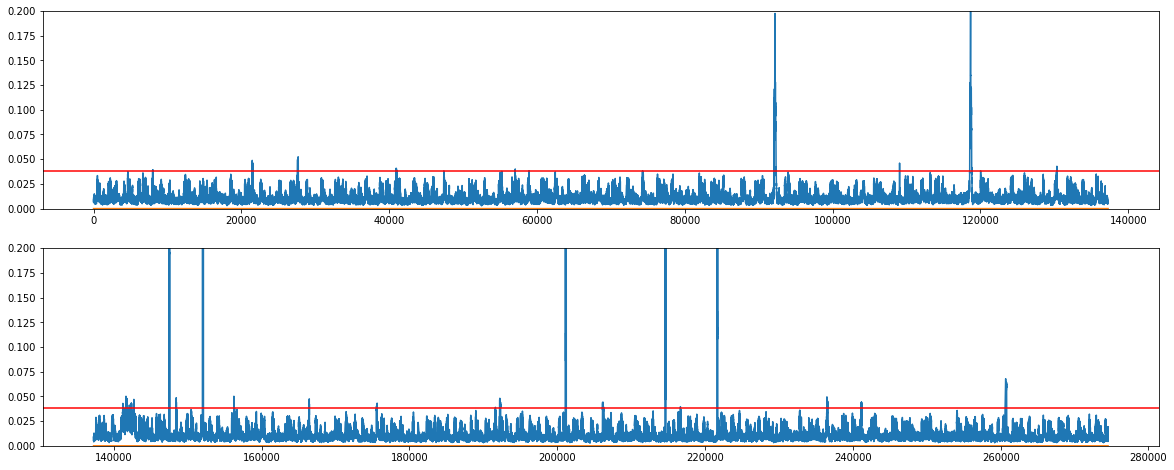

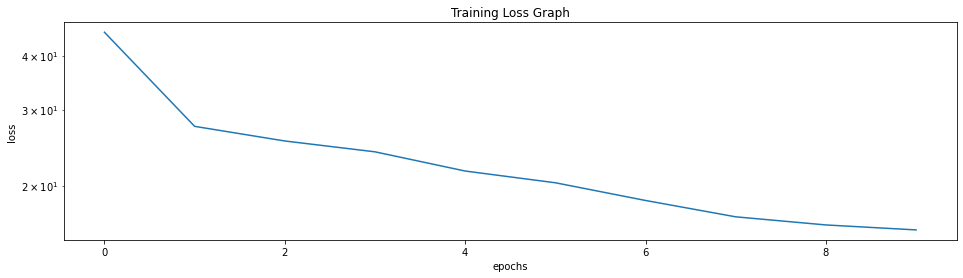

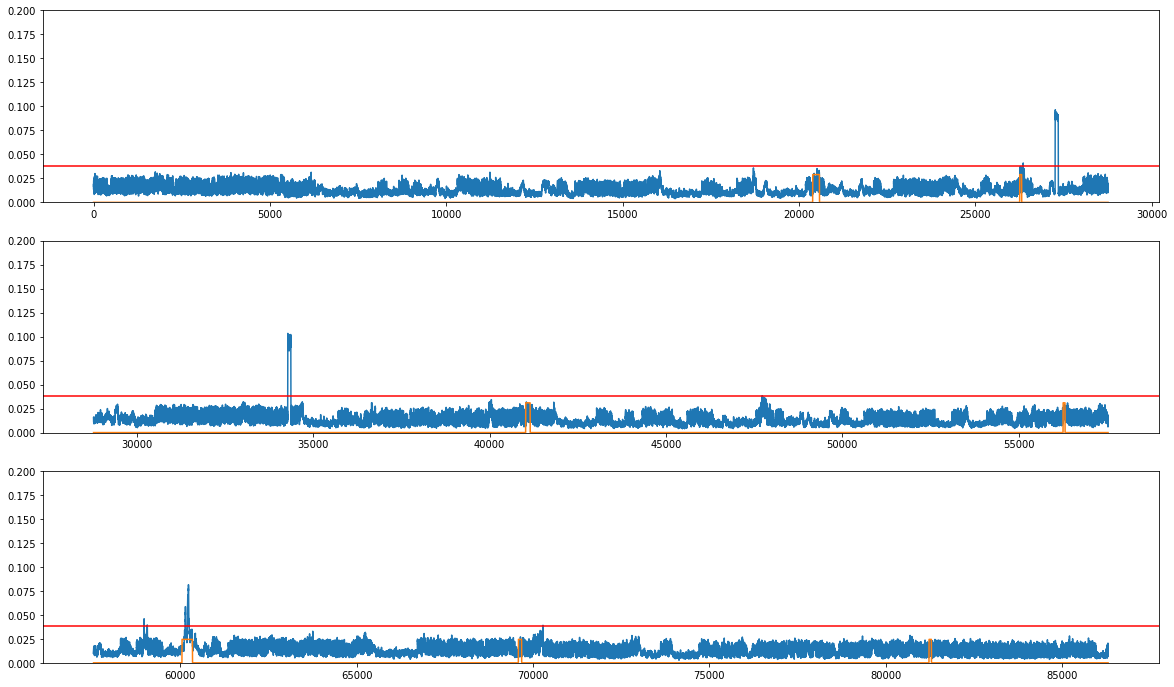

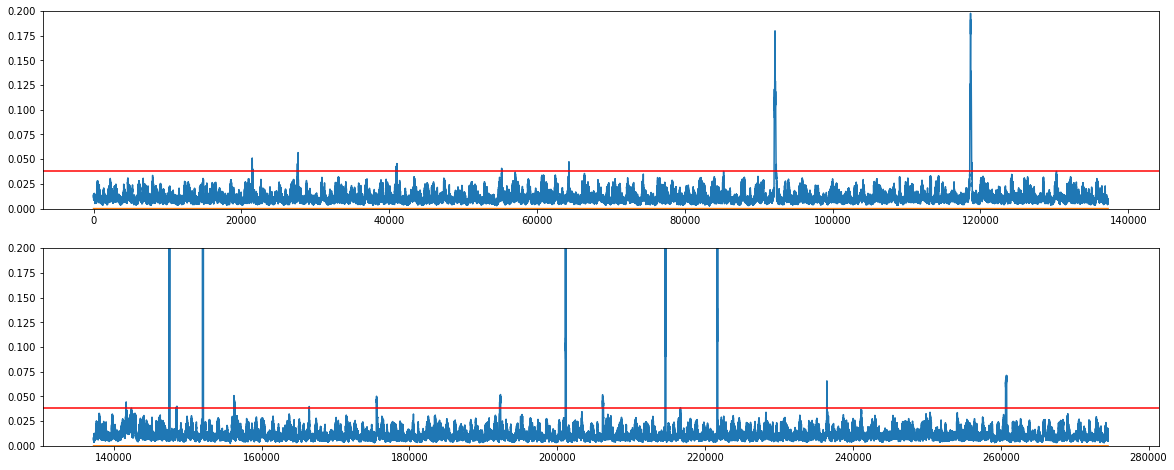

In [ ]:
# WINDOW_GIVEN_LIST 변수와 FOR문을 통해서 Window size가 다른 각 각의 모델을 생성하였음
# 모델의 THRESHOLD가 0.04 수준까지 되었을 때(오탐이 없는), 좋은 모델이라 판단하였음
# 즉, 1번의 모델생성으로 좋은 모델이 생성되기 어렵다. 
# > 모든 seed를 고정시켜 테스팅하는 것은 많은 비용이 발생하기 때문에, 그리고 모델의 랜덤성을 주기 위해 반복적으로 모델을 생성하여 좋은 모델을 선택(각 모델이 상호 보완 될 수 있도록)하였음
WINDOW_GIVEN_LIST = [87,88,89 ]
# Model Config
folderName = PATH + "/output(Create_models)/"
if not os.path.exists(folderName):
  os.makedirs(folderName)


for i in range(len(WINDOW_GIVEN_LIST)):
    Filenum = "E(50)_"
    N_HIDDENS = 50 # 
    N_LAYERS = 3 # 
    #EPOCH = 50 # 
    EPOCH = 10 # 
    WINDOW_GIVEN = WINDOW_GIVEN_LIST[i]
    BATCH_SIZE = 512 #2024
    WINDOW_SIZE = WINDOW_GIVEN + 1
    THRESHOLD = 0.038

    HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)

    MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
    MODEL.cuda()

    # Find Best Model
    MODEL.train()
    BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, EPOCH)
    BEST_MODEL["loss"], BEST_MODEL["epoch"]

    with open(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + "_" + str(N_HIDDENS) + "_" + str(N_LAYERS) + '_' + str(BATCH_SIZE) + "_model.pt", "wb") as f:
        torch.save(
            {
                "state": BEST_MODEL["state"],
                "best_epoch": BEST_MODEL["epoch"],
                "loss_history": LOSS_HISTORY,
            },
            f,
        )
    with open(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + "_" + str(N_HIDDENS) + "_" + str(N_LAYERS) + '_' + str(BATCH_SIZE) + "_model.pt", "rb") as f:
        SAVED_MODEL = torch.load(f)

    torch.cuda.empty_cache()

    MODEL.load_state_dict(SAVED_MODEL["state"])

    plt.figure(figsize=(16, 4))
    plt.title("Training Loss Graph")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.plot(SAVED_MODEL["loss_history"])
    plt.savefig(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS) + '_' + str(N_LAYERS) + '_' + str(BATCH_SIZE) + "_loss.png")
    with open(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS) + '_' + str(N_LAYERS) + '_' + str(BATCH_SIZE) + "_loss_history.txt", 'w') as f:
        with redirect_stdout(f):
            print(SAVED_MODEL["loss_history"])

    # Validation Check
    HAI_DATASET_VALIDATION = HaiDataset(VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD])

    # Model Load
    with open(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS) + '_' + str(N_LAYERS) + '_' + str(BATCH_SIZE) + "_model.pt", "rb") as f:
        SAVED_MODEL = torch.load(f)

    MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
    MODEL.load_state_dict(SAVED_MODEL["state"])
    MODEL.to(torch.device("cuda")) # use GPU 

    MODEL.eval()
    CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

    ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
    check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD, Switch=1)

    LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
    LABELS, LABELS.shape

    ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
    ATTACK_LABELS, ATTACK_LABELS.shape

    FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
    FINAL_LABELS.shape

    ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

    # 검증데이터 평가결과 저장
    TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
    with open(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS) + '_' + str(N_LAYERS) + '_' + str(BATCH_SIZE) + '_'+ str(THRESHOLD) + '_evaluation.txt', 'w') as f:
        with redirect_stdout(f):
            print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
            print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
            print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

    torch.cuda.empty_cache()

    HAI_DATASET_TEST = HaiDataset(TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None)

    # Model Load
    with open(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS) + '_' + str(N_LAYERS) + '_' + str(BATCH_SIZE) + "_model.pt", "rb") as f:
        SAVED_MODEL = torch.load(f)

    MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
    MODEL.load_state_dict(SAVED_MODEL["state"])
    MODEL.to(torch.device("cuda")) # use GPU 

    MODEL.eval() 
    CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

    ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
    check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD, Switch=2)
    LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
    LABELS, LABELS.shape

    submission = pd.read_csv(PATH +'/sample_submission.csv') # ------------------ Check 
    submission.index = submission['timestamp']
    submission.loc[CHECK_TS,'attack'] = LABELS
    submission
    submission.to_csv(folderName + str(Filenum) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS) + '_' + str(N_LAYERS) + '_' + str(BATCH_SIZE) + '_'+ str(THRESHOLD) + '_baseline.csv', index=False)

    torch.cuda.empty_cache()
    
    del HAI_DATASET_TRAIN, HAI_DATASET_VALIDATION, HAI_DATASET_TEST

In [ ]:
!nvidia-smi

Wed Sep 15 05:31:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    35W /  70W |   1130MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
help(etapr)

Help on module TaPR_pkg.etapr in TaPR_pkg:

NAME
    TaPR_pkg.etapr

CLASSES
    TaPR_pkg.tapr.TaPR(builtins.object)
        eTaPR
    
    class eTaPR(TaPR_pkg.tapr.TaPR)
     |  eTaPR(theta_p, theta_r, delta=0.0)
     |  
     |  Method resolution order:
     |      eTaPR
     |      TaPR_pkg.tapr.TaPR
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, theta_p, theta_r, delta=0.0)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  eTaP(self) -> float
     |  
     |  eTaP_d(self) -> list
     |  
     |  eTaP_p(self) -> float
     |  
     |  eTaR(self) -> float
     |  
     |  eTaR_d(self) -> list
     |  
     |  eTaR_p(self) -> float
     |  
     |  point_adjust_precision(self, theta: float) -> float
     |      # point adjust precision
     |  
     |  point_adjust_recall(self, theta: float) -> float
     |  
     |  precision(self) -> float
     |      # conventional precision
     |  
   

In [ ]:
ss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dacon/HAICon2021/output(Create_models)/E(50)__88_50_3_256_0.04_baseline.csv')
ss['attack'].value_counts()

0.0    273144
1.0      1656
Name: attack, dtype: int64

In [ ]:
VALIDATION_DF_RAW['attack'].value_counts()

0    85515
1      885
Name: attack, dtype: int64